## Variatonal Autoencoder


 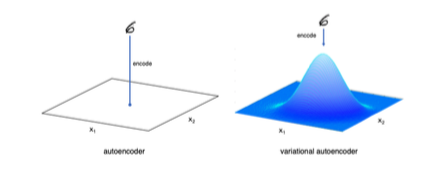
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 
import tensorflow as tf
import keras
from keras.datasets import cifar10
from scipy.stats import norm


To avoid the following error:

TypeError: An op outside of the function building code is being passed a "Graph" tensor. It is possible to have Graph tensors leak out of the function building context by including a tf.init_scope in your function building code. For example, the following function will fail: @tf.function def has_init_scope(): my_constant = tf.constant(1.) with tf.init_scope(): added = my_constant * 2 The graph tensor has name: log_var/Identity:0

Pending to look up 

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Load Dataset 

In [3]:
import os

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


Custom Callbacks

In [4]:
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)

BUILDING THE VAE

In [5]:
import numpy as np
import json
import os
import pickle

In [6]:
class VariatonalAutoencoder():
  def __init__( self,
               input_dim,
               encoder_conv_filters,
               encoder_conv_kernel_size,
               encoder_conv_strides,
               decoder_conv_t_filters,
               decoder_conv_t_kernel_size,
               decoder_conv_t_strides,
               z_dim,
               use_batch_norm = False,
               use_dropout = False      
  ):

    self.name = 'variatonal_autoencoder'

    self.input_dim = input_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.z_dim = z_dim 
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    self.n_layers_encoder = len(encoder_conv_filters)
    self.n_layers_decoder = len(decoder_conv_t_filters)

    self._build()

  def _build(self):

    ## ENCODER
    encoder_input = Input(shape=self.input_dim, name='encoder_input')

    x = encoder_input

    for i in range(self.n_layers_encoder):
        conv_layer = Conv2D(
          filters = self.encoder_conv_filters[i],
          kernel_size = self.encoder_conv_kernel_size[i],
          strides = self.encoder_conv_strides[i],
          padding = 'same',
          name = 'encoder_conv_' + str(i)
              )

        x = conv_layer(x)

        if self.use_batch_norm:
            x = BatchNormalization()(x)

        x = LeakyReLU()(x)

        if self.use_dropout:
            x = Dropout(rate = 0.25)(x)

    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)

    self.mu = Dense(self.z_dim, name='mu')(x)
    self.log_var = Dense(self.z_dim, name='log_var')(x)

    self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

    def sampling(args):
      mu, log_var = args
      epsilon = K.random_normal(shape=K.shape(mu), mean = 0., stddev = 1.)
      return mu + K.exp(log_var /2) * epsilon
    
    encoder_output = Lambda(sampling, name = 'encoder_output')([self.mu, self.log_var])

    self.encoder = Model(encoder_input, encoder_output)


    ### DECODER


    decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    for i in range(self.n_layers_decoder):
        conv_t_layer = Conv2DTranspose(
            filters = self.decoder_conv_t_filters[i],
            kernel_size = self.decoder_conv_t_kernel_size[i],
            strides = self.decoder_conv_t_strides[i],
            padding = 'same',
            name = 'decoder_conv_t_' + str(i)
              )

        x = conv_t_layer(x)

        if i < self.n_layers_decoder - 1:
            x = LeakyReLU()(x)
                
        if self.use_batch_norm:
            x = BatchNormalization()(x)
                
        if self.use_dropout:
            x = Dropout(rate = 0.25)(x)
        else:
            x = Activation('sigmoid')(x)
        
    decoder_output = x

    self.decoder = Model(decoder_input, decoder_output)

    ### FULL VAE

    model_input = encoder_input
    model_output = self.decoder(encoder_output)

    self.model = Model(model_input, model_output)

  def compile(self, learning_rate, r_loss_factor):
    self.learning_rate = learning_rate

            ### COMPILATION
    def vae_r_loss(y_true, y_pred):
        r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
        return r_loss_factor * r_loss

    def vae_kl_loss(y_true, y_pred):
        kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
        return kl_loss

    def vae_loss(y_true, y_pred):
        r_loss = vae_r_loss(y_true, y_pred)
        kl_loss = vae_kl_loss(y_true, y_pred)
        return  r_loss + kl_loss

    optimizer = Adam(lr=learning_rate)
    self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])



  def save(self, folder):

      if not os.path.exists(folder):
          os.makedirs(folder)
          os.makedirs(os.path.join(folder, 'viz'))
          os.makedirs(os.path.join(folder, 'weights'))
          os.makedirs(os.path.join(folder, 'images'))

      with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
          pickle.dump([
              self.input_dim
              , self.encoder_conv_filters
              , self.encoder_conv_kernel_size
              , self.encoder_conv_strides
              , self.decoder_conv_t_filters
              , self.decoder_conv_t_kernel_size
              , self.decoder_conv_t_strides
              , self.z_dim
              , self.use_batch_norm
              , self.use_dropout
              ], f)

      self.plot_model(folder)


  def load_weights(self, filepath):
       self.model.load_weights(filepath)

  def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

       custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
       lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
       
       checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
       checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
       checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

       callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

       self.model.fit(     
           x_train
           , x_train
           , batch_size = batch_size
           , shuffle = True
           , epochs = epochs
           , initial_epoch = initial_epoch
           , callbacks = callbacks_list
       )

  def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

       custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
       lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
       checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
       checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
       checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

       callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

       self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                
       self.model.fit_generator(
           data_flow
           , shuffle = True
           , epochs = epochs
           , initial_epoch = initial_epoch
           , callbacks = callbacks_list
           , steps_per_epoch=steps_per_epoch 
           )

  def plot_model(self, run_folder):
       plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
       plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
       plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)



### Training

In [7]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = '/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

In [8]:
if not os.path.exists(RUN_FOLDER):
    #os.mkdir('/content/run/')
    os.mkdir('/run/vae/')
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [9]:

vae = VariatonalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [10]:
vae.encoder.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu[0][0]                
_______________________________________________________________________________________

In [11]:
vae.decoder.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
activation (Activation)      (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)       

In [12]:

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [13]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)


In [14]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [15]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [16]:
vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 60000 samples
Epoch 1/200
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
59968/60000 [============================>.] - ETA: 0s - loss: 66.0565 - vae_r_loss: 63.7645 - vae_kl_loss: 2.2920
Epoch 00001: saving model to /run/vae/0002_digits/weights/weights-001-66.05.h5

Epoch 00001: saving model to /run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 11s 184us/sample - loss: 66.0510 - vae_r_loss: 63.7586 - vae_kl_loss: 2.2924
Epoch 2/200
59936/60000 [============================>.] - ETA: 0s - loss: 55.3210 - vae_r_loss: 51.9123 - vae_kl_loss: 3.4086
Epoch 00002: saving model to /run/vae/0002_digits/weights/weights-002-55.32.h5

Epoch 00002: saving model to /run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 11s 183us/sample - loss: 55.3222 - vae_r_loss: 51.9134 - vae_kl_loss: 3.4088
Epoch 3/200
59872/60000 [============================>.] - E

### Analysis

Reconstructing original paintings

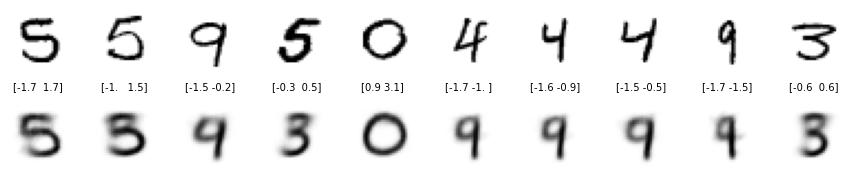

In [17]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

Mr. N Coders Wall

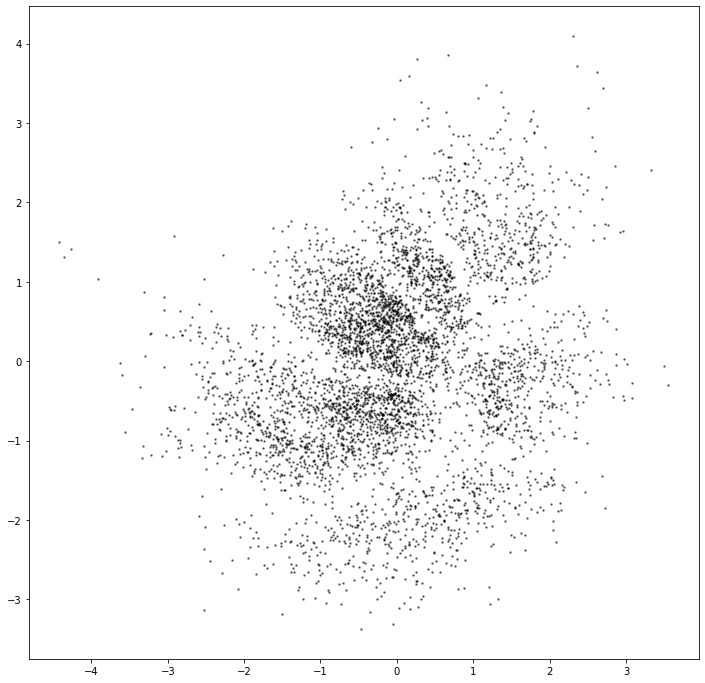

In [18]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

Generated Art Exhibition

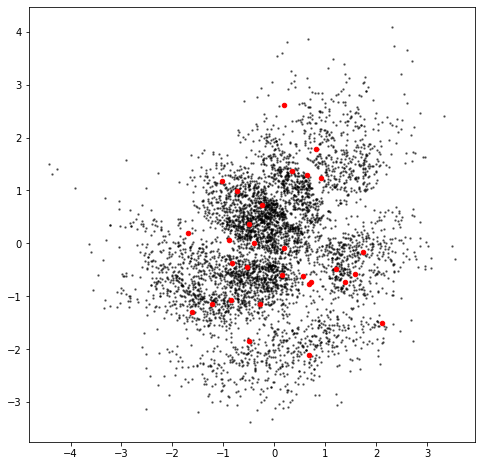

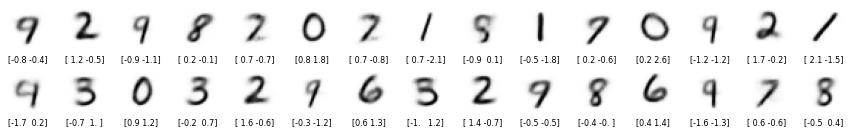

In [19]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

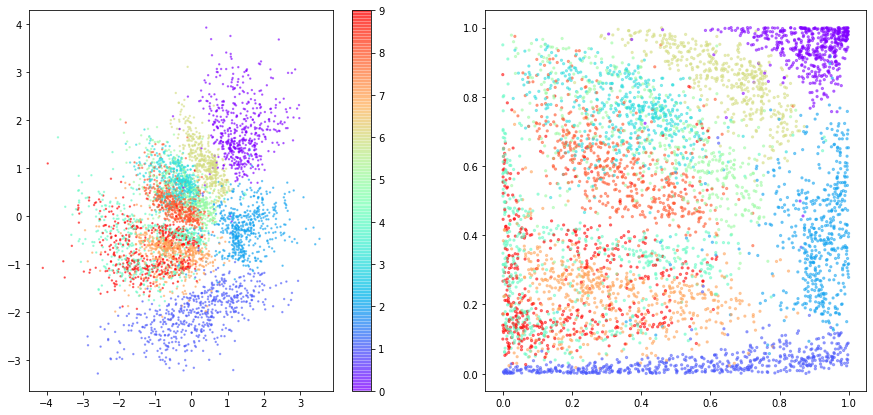

In [23]:

n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

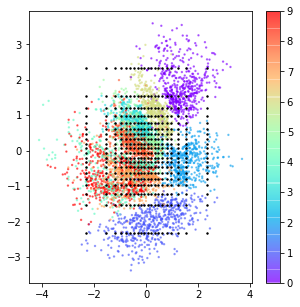

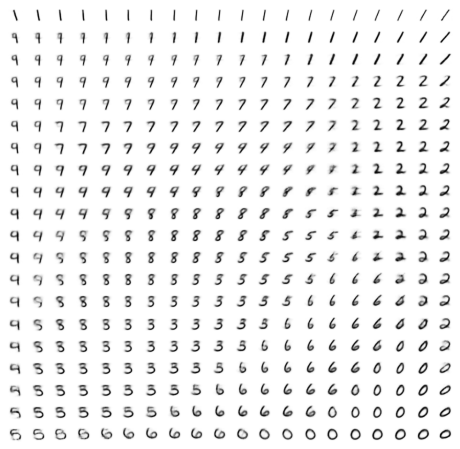

In [24]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')